In [1]:
# should be from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.loggers.comet import CometLogger

In [2]:
import glob
from PIL import Image
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [3]:
from torch.optim.lr_scheduler import StepLR

In [4]:
import pytorch_lightning as pl

In [5]:
%load_ext tensorboard

In [6]:
from pytorch_lightning.core.lightning import LightningModule

# Homework 2, part 1

## transfer learning
1. below you will find the dataset object for the galaxy dataset from homework 1, except that now it outputs a 69x69 image (no flattening), and the single grayscale channel is repeated 3 times to give a 3x69x69 image

2. load a pre-trained network from pytorchs selection https://pytorch.org/docs/stable/torchvision/models.html

3. create a network to classify the galaxy image dataset with some parts from the pretrained network

4. train the new network

5. when you reach over 75% accuracy on the validation dataset, submit your trained model (state_dict and source code)

6. double check that if you train the same model without the pre-trained weights, it will perform worse (no need to submit this model) 

In [7]:
path_to_training_data = '../GalaxyDataset/train/'
path_to_validation_data = '../GalaxyDataset/validation/'

In [8]:
import glob
from PIL import Image
from PIL import ImageFilter
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


class CustomDataset(Dataset):
    def __init__(self, path,mean=0.092,std=0.127,n_classes=10,transform=False):
        
        self.mean = mean
        self.std = std
        
        self.do_transform = transform
        self.transform = transforms.RandomRotation(180)
        
        self.filelist = glob.glob(path+'/*.png')
        
        self.labels = np.zeros(len(self.filelist))
        
        for class_i in range(n_classes):
            self.labels[ np.array(['class'+str(class_i) in x for x in self.filelist]) ] = class_i
        self.labels = torch.LongTensor(self.labels)
        
        
    def __len__(self):
       
        return len(self.filelist)

    def __getitem__(self, idx):
        
        img = Image.open(self.filelist[idx])
    
        if self.do_transform:
            
            img = self.transform(img)
        
        
        x = transforms.ToTensor()(img)
        
        x = (x-self.mean)/self.std
        # vgg16 inp RGB (3 channels). natively in grayscale, repeat channel 3x
        x = x.repeat(3,1,1)
        
        
        class_label = self.labels[idx]
        
        return x, class_label

In [9]:
train_ds = CustomDataset(path_to_training_data,transform=False)
valid_ds = CustomDataset(path_to_validation_data,transform=False)

In [10]:
len(train_ds.labels)

10000

In [11]:
len(valid_ds.labels)

5000

In [12]:
x,y = train_ds[553]

In [13]:
x.shape

torch.Size([3, 69, 69])

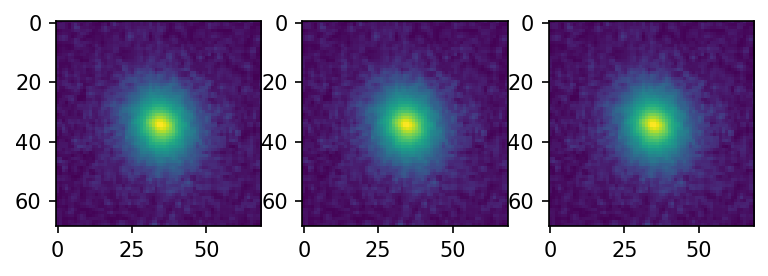

In [14]:
fig,ax = plt.subplots(1,3,figsize=(6,2),dpi=150)

for i in range(3):
    ax[i].imshow(x[i])

In [15]:
NUM_CLASSES = 10
BATCH_SIZE = 32
NUM_EPOCHS = 2
FEAT_EXTRACT = True

In [16]:
import torchvision.models as models


vgg16 = models.vgg16(pretrained=True)
#vgg16 = models.vgg16(pretrained=False)

In [17]:

# necessary?
# Freeze training for all layers --except layers introduced (last fc)
for param in vgg16.features[:24]:
    param.require_grad = False

# Newly created modules have require_grad=True by default

In [18]:
??vgg16

Signature:       vgg16(*input, **kwargs)
Type:            VGG
String form:    
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(i

In [19]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [20]:
LOSS_FUNC = F.cross_entropy

In [21]:
# class ImageClassifier(nn.Module):
class LitImgClassifier(pl.LightningModule):
    def __init__(self):
#         super(LitImgClassifier, self).__init__()
        
        super().__init__()
        
        #you can take all of the conv layers before the max pooling, --does this also grab max pool?
#         self.features = vgg16.features
        
#         #or you can take a subset of them
#         self.conv1 = vgg11.features[0]
#         self.conv2 = vgg11.features[3]
#         self.conv3 = vgg11.features[6]
        
#         #if you want to use subsets of a sequential model:
# pool at layers 4, 9, 16, 23, 30 
        self.features = nn.Sequential(*[vgg16.features[i] for i in range(31)])
        # mod by feats
        self.avgpool = nn.AdaptiveAvgPool2d((2,2))
        # mod by feats
        self.classifier = nn.Sequential(
        
            # mod by feat
            nn.Linear(2*2*512,4096),
            
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            #num_classes = 10
            nn.Linear(4096, NUM_CLASSES),
        )
        
    def forward(self, x):
        out = self.features(x)
        # what does this accomplish 
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.classifier(out)
        
        ##### pass through the rest of your model
        
        return out
    
    def train_dataloader(self):
        dataset_train = CustomDataset(path_to_training_data)
# seemingly CustomDataset handles transformations, tensor...collate_fn=_collate unnecessary                
        return DataLoader(dataset_train,batch_size=BATCH_SIZE,shuffle=True)

    def val_dataloader(self):
        dataset_val = CustomDataset(path_to_validation_data)
        return DataLoader(dataset_val,batch_size=BATCH_SIZE,shuffle=False)
    
    def configure_optimizers(self):
        optimizer1 = torch.optim.Adam(self.parameters(), lr=1e-3)
        # does pl handle step_size?
        scheduler1 = StepLR(optimizer1, step_size=1)
        return [optimizer1], [scheduler1]
        
    
    def training_step(self,batch,batch_idx):
        minib,target = batch
        out = self.forward(minib)
        loss = LOSS_FUNC(out,target)
        # add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}
#         return loss
    
    def validation_step(self,batch,batch_idx):
        minib, target = batch
        out = self.forward(minib)
        loss = LOSS_FUNC(out,target)
        
        pred = out.argmax(dim=1, keepdim=True) #get ix of max log-proba
        correct = pred.eq(target.view_as(pred)).sum().item()
        
        return {'val_loss': loss, 'correct': correct}
        
    
    def validation_epoch_end(self,outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss':avg_loss}
        return {'avg_val_loss':avg_loss, 'log':tensorboard_logs}
        

--test pl lightning--

In [22]:
import os
# details in local .comet.config
comet_logger = CometLogger(
    api_key='n0QCcEJ7YYeDUkff49kqLEdeJ',
    save_dir='.',  # Optional
    experiment_name='vgg16layer31data1_epch50fzn0-23'  # Optional
)

CometLogger will be initialized in online mode
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ren-e1011/general/b307179380304f819ce9e51a5d146838



In [23]:
net = LitImgClassifier()

In [24]:
trainer = pl.Trainer(max_epochs=50, logger=comet_logger)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.


In [25]:
trainer.fit(net)


   | Name         | Type              | Params
-----------------------------------------------
0  | features     | Sequential        | 14 M  
1  | features.0   | Conv2d            | 1 K   
2  | features.1   | ReLU              | 0     
3  | features.2   | Conv2d            | 36 K  
4  | features.3   | ReLU              | 0     
5  | features.4   | MaxPool2d         | 0     
6  | features.5   | Conv2d            | 73 K  
7  | features.6   | ReLU              | 0     
8  | features.7   | Conv2d            | 147 K 
9  | features.8   | ReLU              | 0     
10 | features.9   | MaxPool2d         | 0     
11 | features.10  | Conv2d            | 295 K 
12 | features.11  | ReLU              | 0     
13 | features.12  | Conv2d            | 590 K 
14 | features.13  | ReLU              | 0     
15 | features.14  | Conv2d            | 590 K 
16 | features.15  | ReLU              | 0     
17 | features.16  | MaxPool2d         | 0     
18 | features.17  | Conv2d            | 1 M   
19 | featur

/Users/renee/opt/anaconda3/envs/dl1010/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/renee/opt/anaconda3/envs/dl1010/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


Detected KeyboardInterrupt, attempting graceful shutdown...
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/ren-e1011/general/b307179380304f819ce9e51a5d146838
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [709]   : (0, 21)
COMET INFO:     loss [688]    : (0.27940475940704346, 2.345618963241577)
COMET INFO:     val_loss [21] : (0.8264457583427429, 1.2091368436813354)
COMET INFO:   Others:
COMET INFO:     Name : vgg16layer31data1_epch50fzn0-23
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (6 KB)
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (653 KB)
COMET INFO:     installed packages       : 1
COMET INFO: --------------------

1

In [43]:
comet_logger.experiment.display()

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ren-e1011/general/0cf1d04fa78046418da02069a084db2e



In [ ]:
lr_finder = trainer.lr_find(model)

In [30]:
def dataset_accuracy(tensor_dataset,targets,net):
    
    net.eval()
    
    net.cpu()
    
    output = net(tensor_dataset)
    
    loss = nn.CrossEntropyLoss()(output,torch.LongTensor(targets)) 

    output = output.data.numpy()
    prediction = np.argmax(output,axis=1)

    n_correct = len(np.where(targets==prediction)[0])
    n_total = len(targets)
    
    if torch.cuda.is_available():
        net.cuda()
    return n_correct/n_total, loss.item()

In [27]:
validation_tensor = torch.stack([valid_ds[i][0] for i in range(len(valid_ds)) ])
validation_labels = valid_ds.labels.data.numpy()

In [28]:
dataset_accuracy(validation_tensor,validation_labels, net)

(0.693, 0.8238099813461304)

In [32]:
torch.save(net.state_dict(),'vgg16layer31data1fzn0-23.pt')

In [34]:
dataset_accuracy(training_tensor[:16],training_labels[:16],testlt)

(0.125, 2.27748703956604)

In [35]:
training_tensor[:16].shape

torch.Size([16, 3, 69, 69])